In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline
plt.rcParams['font.family'] =  'sans-serif'

TEXT_PATH = './scraping_pickle_dir/'
VALUE_PATH = './bitcoin_value/'
STOP_WORD_PATH = './stopwords.txt'

/Users/ono/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
file = open(STOP_WORD_PATH, 'r')  #読み込みモードでオープン
word = file.readline()   #readlineで1行だけ読み込む
stop_word_list = []
while word:
    word = word.replace('\n','')
    stop_word_list.append(word)
    word = file.readline()


In [3]:
text_name_list = sorted(os.listdir(TEXT_PATH))

value_path_list = sorted(os.listdir(VALUE_PATH))

In [4]:
df_main_bitcoin_list = []
for value_path in value_path_list:
    df_bitcoin =  pd.read_csv(os.path.join(VALUE_PATH,value_path))
    df_bitcoin_dropna = df_bitcoin.dropna()
    df_main_bitcoin_list.append(df_bitcoin_dropna)

df_main_bitcoin = pd.concat(df_main_bitcoin_list)
df_main_bitcoin = df_main_bitcoin.drop_duplicates().reset_index(drop=True)

In [5]:
def trans_name(_x):
    year = _x[:4]
    month = _x[5:7]
    day = _x[8:10]
    hour = _x[11:13]
    minute = _x[14:16]
    if int(minute)==45:
        next_minute = str(0)
    else:
        next_minute =str(int(minute)+15)
    trans_name = '{}{}{}{}_{}_{}.pickle' .format(year,month,day,hour,minute,next_minute)
    return trans_name


#スクレイピング したデータのファイルがあるかチェックする
def confirmation_date(_x):
    if str(_x) in text_name_list:
        return True
    return False 

#最大と最小
def get_mean_bitcoin(_x):
    high,low = _x
    #有効数字10桁
    return (high+low)/2

df_main_bitcoin['data_name'] = df_main_bitcoin['Date'].apply(trans_name)
df_main_bitcoin['is_data'] = df_main_bitcoin['data_name'].apply(confirmation_date)
df_main_bitcoin['Mean'] = df_main_bitcoin.loc[:,['High','Low']].apply(get_mean_bitcoin,axis=1)

/Users/ono/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


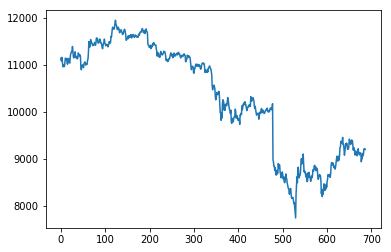

In [6]:
plt.plot(df_main_bitcoin['Close'])

/Users/ono/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


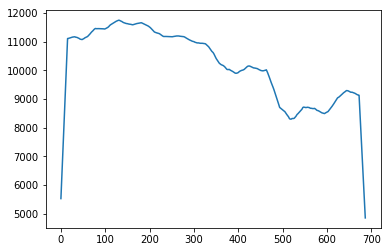

In [7]:
#移動平均をとってスムージング
num_smooth = 30
kernel = np.ones(num_smooth)/num_smooth
smoothed = np.convolve(df_main_bitcoin['Close'], kernel, mode='same')
df_main_bitcoin['Close_smooth'] = smoothed
plt.plot(smoothed[:])

In [8]:
#平均の変化量計算
diff_mean_array = np.array(df_main_bitcoin['Close_smooth'][1:])-np.array(df_main_bitcoin['Close_smooth'][:-1])


label = np.array([0 if diff_mean<0 else 1 for diff_mean in diff_mean_array])

#最初は測れないからとりあえず0にする
label = np.append(np.array([0]), label)

df_main_bitcoin['label'] = label

#端はうまくスムージングされていないから抜く
df_main_bitcoin = df_main_bitcoin[num_smooth:-num_smooth]

df_main_bitcoin_is_data = df_main_bitcoin[df_main_bitcoin.is_data==True]

In [13]:

#絵文字やURLなどを削除
def eliminate_character(_text):
    _text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', '', _text,)
    _text = re.sub("["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
                               "]+", '', _text,)
    _text = re.sub(r'@[\w]+', '', _text,)
    _text=re.sub('RT|#', "", _text)
    _text=re.sub('\n', " ", _text)
    _text=re.sub(r'[︰-＠]', "", _text)
    _text=re.sub(r'^[!-~]+$', "", _text)

    return _text

In [14]:
corpus_list =[]
corpus_list_flatten = []
for file_path in np.array(df_main_bitcoin_is_data['data_name']):
    dict_data =  pickle.load(open(os.path.join(TEXT_PATH,file_path),'rb'))
    test_corpus =' '.join([eliminate_character(_dict['text']) for _dict in dict_data])
    test_corpus = test_corpus.split()
    #test_corpus =[eliminate_character(_dict['text']) for _dict in dict_data]
    corpus_list_flatten +=test_corpus
    corpus_list.append(' '.join(test_corpus))
        
    

In [15]:
import collections

corpus_counter = collections.Counter(corpus_list_flatten)

corpus_counter_sort = sorted(corpus_counter.items(), key=lambda x: x[1],reverse=True)

In [17]:
corpus_counter_stopword = [word for word,num in corpus_counter.items() if num < 5 ]

In [19]:
#ストップワードに追加
stop_word_list +=corpus_counter_stopword

In [20]:
#ベクトル化
#vectorizer = TfidfVectorizer(use_idf=True)

vectorizer = TfidfVectorizer(use_idf=True,stop_words = stop_word_list)
tfidfs = vectorizer.fit_transform(corpus_list)


In [21]:
#データ数とデータの各データの次元
tfidfs.toarray().shape

(469, 71384)

In [22]:
#ラベルデータ
label_array = np.array(df_main_bitcoin_is_data['label'])

In [23]:
#labelの偏りを計算
import collections
collections.Counter(label_array)

Counter({0: 292, 1: 177})

In [24]:
X_train, X_test,y_train, y_test = train_test_split(tfidfs.toarray(), label_array, test_size=0.3, random_state=0)
model = xgb.XGBClassifier()

#学習
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [27]:
#正答率、混合行列、AUCまとめて計算

def evaluate_model(_model,_X_test,_y_test):
    predicted = _model.predict(_X_test)
    expected = _y_test
    print("正解率 : {}".format(metrics.accuracy_score(expected,predicted)))
    confmat = confusion_matrix(y_true=expected, y_pred=predicted)
    
    print("====confusion_matrix====")
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()
    
    print("====ROC curve====")
    probas_ = model.predict_proba(_X_test)
    fpr, tpr, thresholds = roc_curve(_y_test, probas_[:, 1])
    roc_auc_area = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, color='r', lw=2,
             label='ROC curve (area = {:.2f})'.format(roc_auc_area))
    ax.plot([0, 1], [0, 1], color='b', linestyle='--')
    plt.title('ROC curve sample')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    

正解率 : 0.8226950354609929
====confusion_matrix====


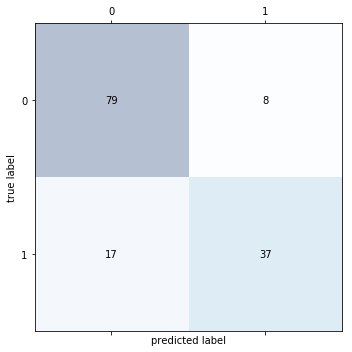

====ROC curve====


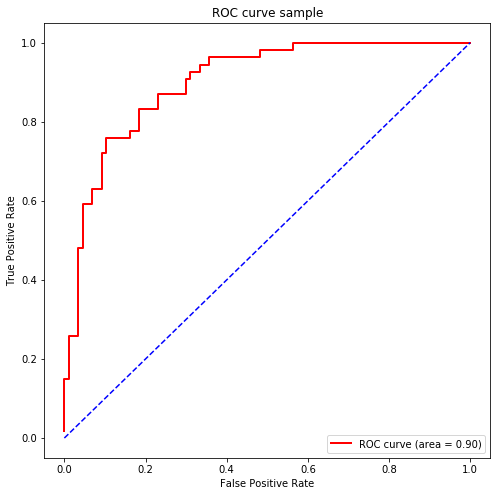

In [32]:

evaluate_model(model,X_test,y_test)

In [29]:
#クロスバリデーションによる検証

from sklearn.model_selection import cross_val_score

score=cross_val_score(estimator=model,
                      X=X_train,
                      y=y_train,
                      cv=5,
                      n_jobs=-1)

print("score %.3f +/- %.3f" %(np.mean(score),np.std(score)))

score 0.814 +/- 0.065


In [29]:
#チューニング

In [30]:

from sklearn.grid_search import GridSearchCV,RandomizedSearchCV

param_test1 = {
    'max_depth':[3,4,5,6,7],
    'min_child_weight':[6,7,8,9,10],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[0,0.05, 0.1,0.2,0.3,0.4],

}
gsearch1 = RandomizedSearchCV(model, param_test1, n_jobs=-1)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Users/ono/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


([mean: 0.77101, std: 0.00280, params: {'subsample': 0.7, 'colsample_bytree': 0.6, 'min_child_weight': 6, 'gamma': 0.4, 'max_depth': 2, 'reg_alpha': 0.09},
  mean: 0.77101, std: 0.03342, params: {'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 6, 'gamma': 0.1, 'max_depth': 3, 'reg_alpha': 0.09},
  mean: 0.76812, std: 0.00679, params: {'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_weight': 6, 'gamma': 0.2, 'max_depth': 3, 'reg_alpha': 0.1},
  mean: 0.73913, std: 0.02963, params: {'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 7, 'gamma': 0.2, 'max_depth': 2, 'reg_alpha': 0.2},
  mean: 0.77101, std: 0.02658, params: {'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'gamma': 0.4, 'max_depth': 7, 'reg_alpha': 0.3},
  mean: 0.77681, std: 0.00833, params: {'subsample': 0.7, 'colsample_bytree': 0.6, 'min_child_weight': 5, 'gamma': 0.0, 'max_depth': 3, 'reg_alpha': 0.09},
  mean: 0.79130, std: 0.02198, params: {'subsample': 0.7, 'colsampl

In [31]:
#学習
eval_test_set = [(X_test, y_test)]

model=xgb.XGBClassifier(n_estimators=100,**gsearch1.best_params_)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_test_set, verbose=True)




[0]	validation_0-logloss:0.673777
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.659334
[2]	validation_0-logloss:0.652103
[3]	validation_0-logloss:0.645436
[4]	validation_0-logloss:0.63738
[5]	validation_0-logloss:0.62742
[6]	validation_0-logloss:0.622011
[7]	validation_0-logloss:0.618924
[8]	validation_0-logloss:0.612774
[9]	validation_0-logloss:0.605998
[10]	validation_0-logloss:0.600943
[11]	validation_0-logloss:0.596147
[12]	validation_0-logloss:0.597147
[13]	validation_0-logloss:0.591425
[14]	validation_0-logloss:0.594597
[15]	validation_0-logloss:0.588044
[16]	validation_0-logloss:0.584686
[17]	validation_0-logloss:0.580437
[18]	validation_0-logloss:0.584158
[19]	validation_0-logloss:0.583154
[20]	validation_0-logloss:0.582253
[21]	validation_0-logloss:0.576391
[22]	validation_0-logloss:0.579686
[23]	validation_0-logloss:0.572847
[24]	validation_0-logloss:0.568952
[25]	validation_0-logloss:0.571071
[26]	validation_0-logloss:0.574784

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=8, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.3, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

正解率 : 0.7315436241610739
====confusion_matrix====


/Users/ono/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


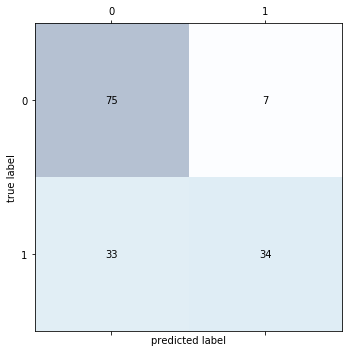

====ROC curve====


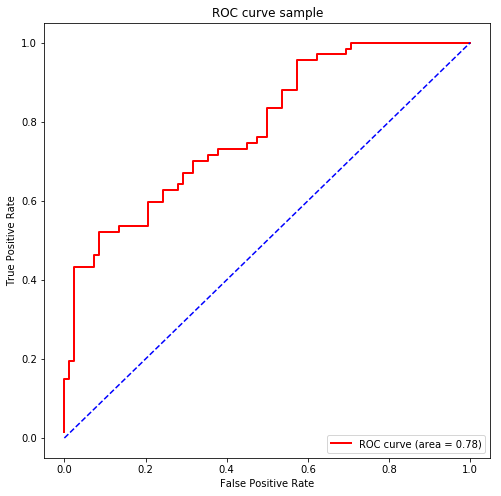

In [32]:
#チューニングは検証データのみで汎化性能をあげようとしたので、
#おそらく、データ量が少ないために、うまくいかなかった

evaluate_model(model,X_test,y_test)